In [1]:
from src import sgru
from src import gru
from src import switch_utils
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import jax
import jax.numpy as jnp
import haiku as hk


In [2]:
data_dir = '/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/data/processed'

# choose mouse, beta and run time
train_prop = 0.7
param = 0.03
cv = f'{train_prop*100:.0f}-{(1-train_prop)*100:.0f}'
split_dt = "2025-04-17_10-28"
batch_size = 64

df_tr = pd.read_csv(os.path.join(data_dir, f"train_df_{cv}_{split_dt}.csv"))
df_va = pd.read_csv(os.path.join(data_dir, f"validation_df_{cv}_{split_dt}.csv"))

ds_tr = switch_utils.get_dataset(df_tr, batch_size)
ds_va = switch_utils.get_dataset(df_va, batch_size)


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

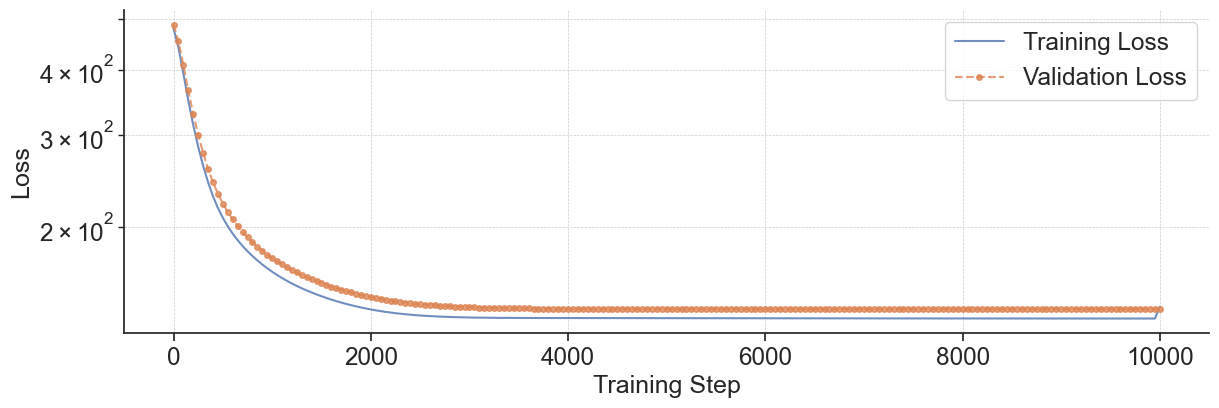

In [3]:
def make_network():
    return sgru.HkSGRU(1,2,4)

params, opt_state, losses = sgru.train_sgru_network(make_network, ds_tr, ds_va, n_steps=1e4, do_plot=True)

In [8]:
output.shape

(978, 158, 2)

In [5]:
def unroll_network(xs):
  core = make_network()
  batch_size = jnp.shape(xs)[1]
  state = core.initial_state(batch_size)
  ys, _ = hk.dynamic_unroll(core, xs, state)
  return ys


_, step_hk = hk.transform(unroll_network)
step_hk = jax.jit(step_hk)

random_key = jax.random.PRNGKey(0)

# first two columns give the probability of left and right (but need to be put through
# softmax for normalising)
output = step_hk(params, random_key, ds_va._xs)[:,:,:2]
# sample from the output either greedily or with thompson sampling
sample_type = 'thompson'
y_sampled = switch_utils.sampler(output, sample_type)
ll = switch_utils.log_likelihood_normalised(ds_va._ys, output)
print(f"The log likelihood for {model_name} is {ll:.3f}.")

Array(-0.19783497, dtype=float32)

(978, 158)


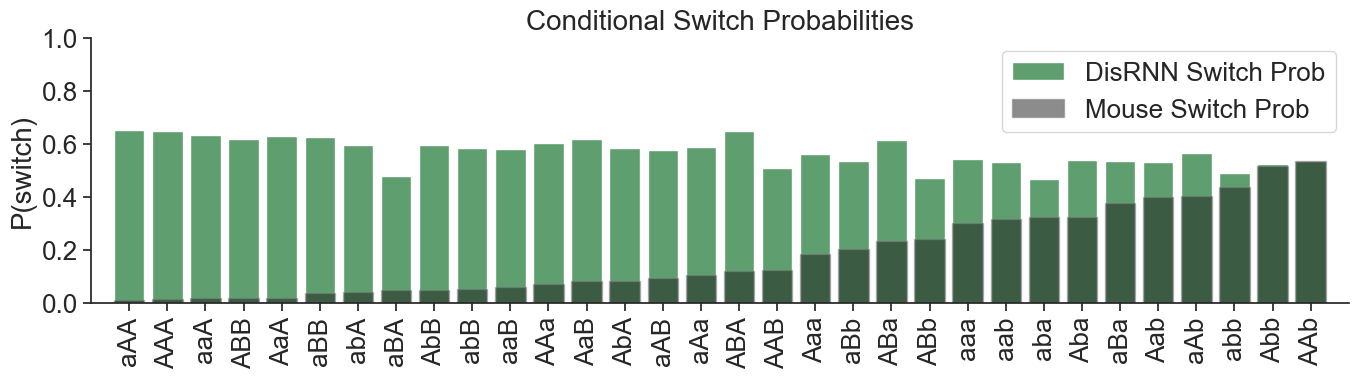

In [6]:
# simulated conditional probability dictionary for each 3 letter history
p_dict = switch_utils.switch_bars(ds_va._xs, ds_va._xs[:,:,0], symm=True, prob=True)
sim_p_dict = switch_utils.switch_bars(ds_va._xs[1:], y_sampled[:-1], symm=True, prob=True)

sorted_items = sorted(p_dict.items(), key=lambda item: item[1])
sorted_keys = [item[0] for item in sorted_items] 
sorted_labels = [item[0] for item in sorted_items]
sorted_heights = [item[1] for item in sorted_items]
sim_sorted_heights = [sim_p_dict[key] for key in sorted_keys]

sns.set(style='ticks', font_scale=1.7, rc={'axes.labelsize':20, 'axes.titlesize':20})
sns.set_palette('deep')


fig, ax = plt.subplots(figsize=(14,4.2))

sns.barplot(x=sorted_labels, y=sim_sorted_heights, color='g', alpha=1, ax=ax, label='DisRNN Switch Prob')
sns.barplot(x=sorted_labels, y=sorted_heights, color='k', alpha=0.5, ax=ax, edgecolor='gray', label='Mouse Switch Prob')

ax.set(xlim=(-1,len(sorted_heights)), ylim=(0,1), ylabel='P(switch)')
plt.xticks(rotation=90)
sns.despine()
plt.title('Conditional Switch Probabilities')
plt.tight_layout()
plt.legend()
# plt.savefig('/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/figs/switch_probs.pdf')
plt.show()